# Filtering Signals

In this notebook, you will get more familiar with filtering data. In the first part, we will go over some examples of creating signals, combining them, and then applying filters to separate the components.

## Filter Types

Filters are separated into two types: lowpass and highpass. The distinction is based on which frequency band the filters tend to keep. Lowpass filters allow frequencies lower than the cutt-off frequency to pass through, whereas highpass filters perform the opposite operation by allowing frequencies higher than the cut-off frequency and cutting off lower frequencies.

If you want to read more about filter design in analog and digital domains, I highly encourage you to read the free ebook provided here:

[DSPRelated.com - Introduction to Digital Filters](https://www.dsprelated.com/freebooks/filters/)

In [1]:
# Importing useful libraries:
# NumPy for calculations
# SciPy for filtering operations
# Matplotlib for plotting
import numpy as np
import scipy.signal as sig
import matplotlib.pyplot as plt

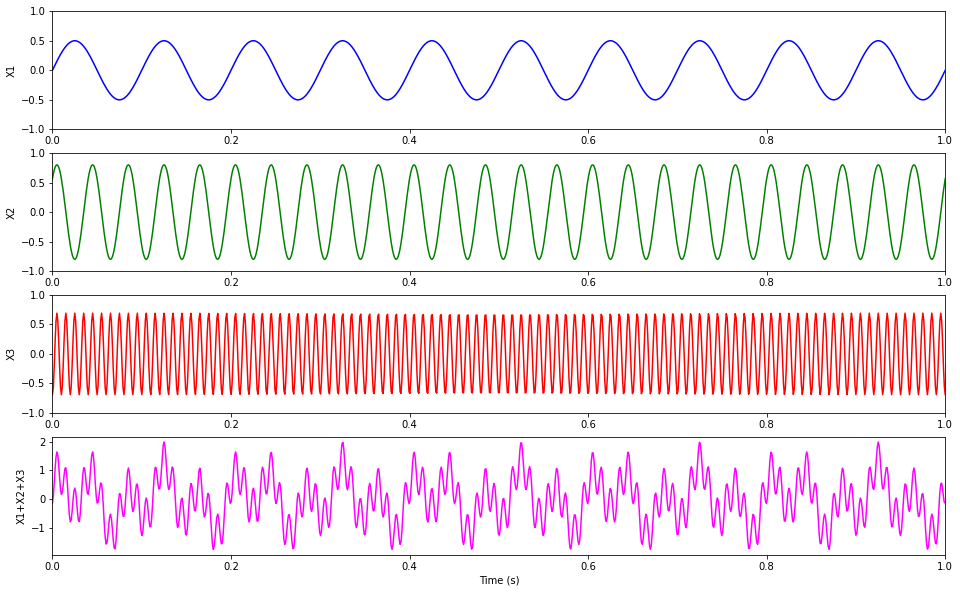

In [2]:
# Let's make some signals, sampled at 1000Hz
fs = 1000    # sampling frequency
dt = 1/fs    # sampling interval
T  = 1       # duration of 1 second
t  = np.linspace(0,1,fs) # time vector

# signal #1 is a sine wave of f1 = 10 Hz and phase of 0 rad
alpha1=0.5
f1 = 10
phi1 = 0
x1 = alpha1*np.sin(2*np.pi*f1*t + phi1)

# signal #2 is a sine wave of f2 = 25 Hz and phase of pi/4 rad
alpha2 = 0.8
f2 = 25
phi2 = np.pi/4
x2 = alpha2*np.sin(2*np.pi*f2*t + phi2)

# signal #3 is a sine wave of f3 = 100 Hz and phase of 3pi/2 rad
alpha3=0.69
f3 = 100
phi3 = 3*np.pi/2
x3 = alpha3*np.sin(2*np.pi*f3*t + phi3)

# signal y is the superposition of all 3 signals
y = x1+x2+x3

# And let's plot the signals
plt.figure(num=1,figsize=[16,10])
plt.subplot(411)
plt.plot(t,x1,color='blue')
plt.xlim([0,1])
plt.ylim([-1,1])
plt.ylabel('X1')
plt.subplot(412)
plt.plot(t,x2,color='green')
plt.xlim([0,1])
plt.ylim([-1,1])
plt.ylabel('X2')
plt.subplot(413)
plt.plot(t,x3,color='red')
plt.xlim([0,1])
plt.ylim([-1,1])
plt.ylabel('X3')
plt.subplot(414)
plt.plot(t,y,color='magenta')
plt.xlim([0,1])
plt.ylabel('X1+X2+X3')
plt.xlabel('Time (s)')
plt.show()

The magenta signal is the superposition of all three signals. As you can see, this signal is erratic and you can't really see the different components that comprise the full signal easily. What we can do, is perform a spectral analysis! So let's plot the FFT of the combined signal.

For more information on the FFT, see the SciPy documentation [here](https://docs.scipy.org/doc/scipy/reference/tutorial/fft.html#discrete-sine-transforms).

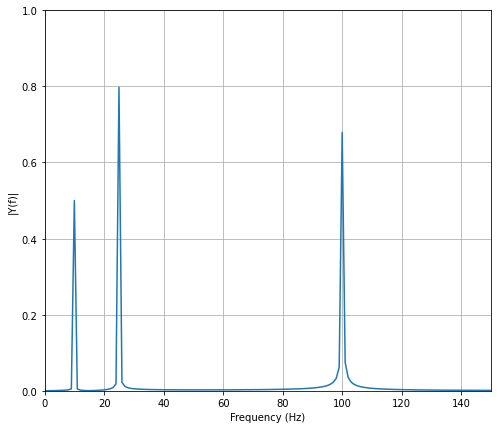

In [3]:
from scipy.fft import fft,fftfreq

N = len(y) # number of FFT points (length of signal)

Y = fft(y) # calculate the FFT
fv = fftfreq(N, dt)[:N//2] # make the frequency vector

plt.figure(num=4,figsize=[8,7])
plt.plot(fv, 2.0/N * np.abs(Y[0:N//2]))
plt.xlim([0,150])
plt.ylim([0,1])
plt.xlabel('Frequency (Hz)')
plt.ylabel('|Y(f)|')
plt.grid()
plt.show()

Here we go, three distinct peaks, centered at the frequencies of the individual components, with their respective amplitudes. So we can tell that our combined signal $y(t)=x_1(t)+x_2(t)+x_3(t)$ has three frequency components at the frequencies 10, 20, and 100 Hz, with amplitudes of 0.5, 0.8, and 0.69 respectively.

## Filtering the signal

In this section, we will use the SciPy module's function _butter()_ to make our filters. If you would like to learn more about the process, the documentation is provided [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.butter.html).

### Lowpass filtering

Now that we've identified the three frequency components of our signal $y(t)$, let's make a filter to cut the 100 Hz frequency out. We will use the following functions:

In [35]:
# Let's define a function for low-pass filtering using a digital Butterworth filter
def butter_lowpass(cutoff, fs, order=5):
    fnyq = 0.5 * fs
    normal_cutoff = cutoff / fnyq
    b, a = sig.butter(order, normal_cutoff, btype='low', output='ba', fs=2, analog=False)
    return b, a

# And a second function for high-pass filtering
def butter_highpass(cutoff, fs, order=5):
    fnyq = 0.5 * fs
    normal_cutoff = cutoff / fnyq
    b, a = sig.butter(order, normal_cutoff, btype='high', output='ba', fs=2, analog=False)
    return b, a

# This function filters the input data and returns the filtered sequence
def butter_filter(data, cutoff, fs, order=5, filtype=''):
    if filtype.lower()=='lowpass':
        b, a = butter_lowpass(cutoff, fs, order=order)
    elif filtype.lower()=='highpass':
        b, a = butter_highpass(cutoff, fs, order=order)        
        
    y = sig.filtfilt(b, a, data)
    return y

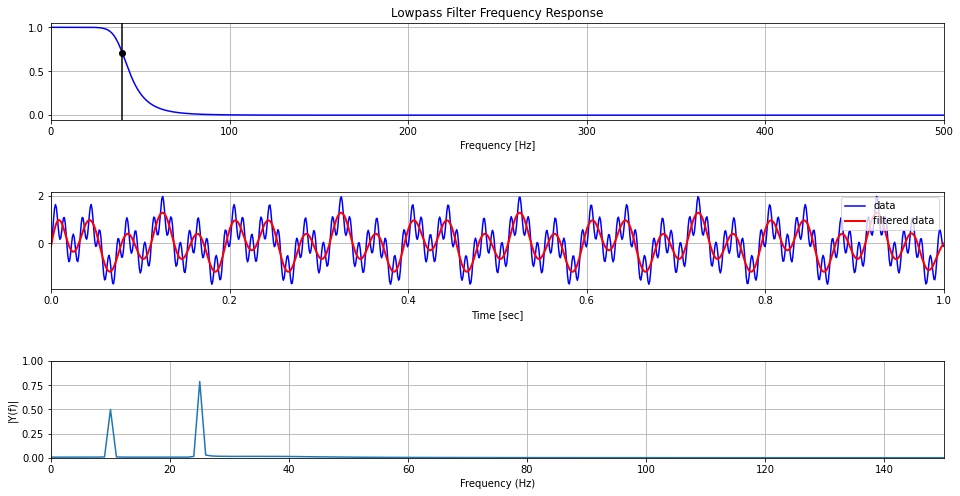

In [36]:
# Make a low-pass filter
order = 6
fc = 40  # desired cutoff frequency of the filter, Hz

# Get the filter coefficients so we can check its frequency response.
b,a = butter_lowpass(fc, fs, order)

# Plot the frequency response.
w, h = sig.freqz(b, a, worN=8000)
plt.figure(figsize=(16,8))
plt.subplot(311)
plt.plot(0.5*fs*w/np.pi, np.abs(h), 'b')
plt.plot(fc, 0.5*np.sqrt(2), 'ko')
plt.axvline(fc, color='k')
plt.xlim(0, 0.5*fs)
plt.title("Lowpass Filter Frequency Response")
plt.xlabel('Frequency [Hz]')
plt.grid()

# Filter the data, and plot both the original and filtered signals.
yf = butter_filter(y, fc, fs, order, 'lowpass')

plt.subplot(312)
plt.plot(t, y, 'b-', label='data')
plt.plot(t, yf, 'r-', linewidth=2, label='filtered data')
plt.xlabel('Time [sec]')
plt.xlim([0,1])
plt.grid()
plt.legend()

# Let's calculate the FFT of the filtered signal and plot the frequency components
N = len(yf) # number of FFT points (length of signal)

Yf = fft(yf) # calculate the FFT
fv = fftfreq(N, dt)[:N//2] # make the frequency vector

plt.subplot(313)
plt.plot(fv, 2.0/N * np.abs(Yf[0:N//2]))
plt.xlim([0,150])
plt.ylim([0,1])
plt.xlabel('Frequency (Hz)')
plt.ylabel('|Y(f)|')
plt.grid()

plt.subplots_adjust(hspace=0.75)
plt.show()

The first figure shows the frequency response of the $6^{th}$ order lowpass Butterworth filter. At 100Hz, the filter completely attenuates the unwanted frequency, as shown in the third figure. The middle panel shows the comparison of the unfiltered signal (in <span style="color:blue">blue</span>) while the filtered version is shown in <span style="color:red">red</span>.

### Highpass filtering

Let's do the opposite: let's remove all frequencies _below_ 100 Hz. As an exercise, fill in the missing code in the cell below:

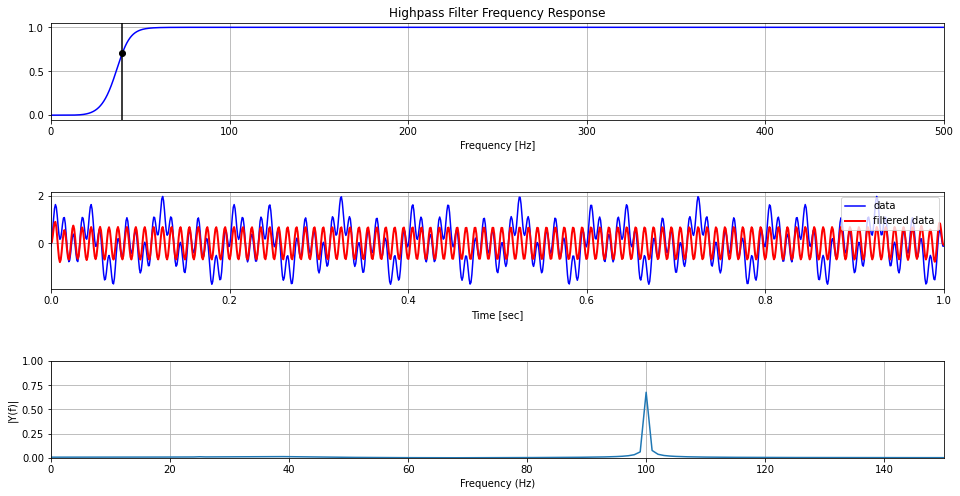

In [38]:
# Make a high-pass filter
order = 6
fc = 40  # desired cutoff frequency of the filter, Hz

# Get the filter coefficients so we can check its frequency response.
b,a = butter_highpass(fc, fs, order)

# Plot the frequency response.
w, h = sig.freqz(b, a, worN=8000)
plt.figure(figsize=(16,8))
plt.subplot(311)
plt.plot(0.5*fs*w/np.pi, np.abs(h), 'b')
plt.plot(fc, 0.5*np.sqrt(2), 'ko')
plt.axvline(fc, color='k')
plt.xlim(0, 0.5*fs)
plt.title("Highpass Filter Frequency Response")
plt.xlabel('Frequency [Hz]')
plt.grid()

# Filter the data, and plot both the original and filtered signals.
yf = butter_filter(y, fc, fs, order, 'highpass')

plt.subplot(312)
plt.plot(t, y, 'b-', label='data')
plt.plot(t, yf, 'r-', linewidth=2, label='filtered data')
plt.xlabel('Time [sec]')
plt.xlim([0,1])
plt.grid()
plt.legend()

# Let's calculate the FFT of the filtered signal and plot the frequency components
N = len(yf) # number of FFT points (length of signal)

Yf = fft(yf) # calculate the FFT
fv = fftfreq(N, dt)[:N//2] # make the frequency vector

plt.subplot(313)
plt.plot(fv, 2.0/N * np.abs(Yf[0:N//2]))
plt.xlim([0,150])
plt.ylim([0,1])
plt.xlabel('Frequency (Hz)')
plt.ylabel('|Y(f)|')
plt.grid()

plt.subplots_adjust(hspace=0.75)
plt.show()
# Calculate the FFT of the filtered signal
N = len(yf) # number of FFT points (length of signal)

Yf = fft(yf) # calculate the FFT
fv = fftfreq(N, dt)[:N//2] # make the frequency vector

In [ ]:
# Plot everything, as before

# Filter's frequency response.
w, h = sig.freqz(b, a, worN=8000)
plt.figure(figsize=(16,8))
plt.subplot(311)
plt.plot(0.5*fs*w/np.pi, np.abs(h), 'b')
plt.plot(fc, 0.5*np.sqrt(2), 'ko')
plt.axvline(fc, color='k')
plt.xlim(0, 0.5*fs)
plt.title("Lowpass Filter Frequency Response")
plt.xlabel('Frequency [Hz]')
plt.grid()

# Plot both the original and filtered signals.
plt.subplot(312)
plt.plot(t, y, 'b-', label='data')
plt.plot(t, yf, 'r-', linewidth=2, label='filtered data')
plt.xlabel('Time [sec]')
plt.xlim([0,1])
plt.grid()
plt.legend()

# Plot the frequency spectrum of the signal
plt.subplot(313)
plt.plot(fv, 2.0/N * np.abs(Yf[0:N//2]))
plt.xlim([0,150])
plt.ylim([0,1])
plt.xlabel('Frequency (Hz)')
plt.ylabel('|Y(f)|')
plt.grid()

plt.subplots_adjust(hspace=0.75)
plt.show()


Hopefully, you were able to solve the exercise above and you filtered out the lower frequencies in the signal! If so, you may notice that the filtered signal is very similar to just $x_3$. Is that the case?



### Bandpass filtering

Now you know how to use filters to attenuate high and low frequencies out of a signal. In real-life scenarios, things are usually a little more complex. Let's say we have a signal that is affected by high-frequency noise. Which filter would you use? What if you had low-frequency noise? Can you imagine how we would attenuate all noise, both low- and high-frequency, while keeping signals in a specific band unaffected? Let's see two examples.

#### Method \#1

We will use the bandpass method provided in the _butter()_ function.

In [ ]:
# Let's add a new frequency to our signal at 200 Hz
alpha4 = 1
phi4 = 0
f4 = 200
x4 = alpha4*np.sin(2*np.pi*f4*t + phi4)

yn = y+x4

In [ ]:
# Let's define a function for band-pass filtering as before
def butter_bandpass(cutoff, fs, order=5):
    if len(cutoff)!=2:
        print('error: please define frequencies as [fcl, fch] in Hz!')
        return -1
    
    fnyq = 0.5 * fs
    normal_cutoff = cutoff / fnyq
    b, a = sig.butter(order, normal_cutoff, btype='band', analog=False)
    return b, a

# Modify this function so that it filters the input data and returns the filtered sequence even as a bandpass
def butter_filter(data, cutoff, fs, order=5, filtype=''):
    if filtype.lower()=='lowpass':
        b, a = butter_lowpass(cutoff, fs, order=order)
    elif filtype.lower()=='highpass':
        b, a = butter_highpass(cutoff, fs, order=order)
    elif filtype.lower()=='bandpass':
        b, a = butter_bandpass(cutoff, fs, order=order)
        
    y = sig.filtfilt(b, a, data)
    return y

In [ ]:
# Make a band-pass filter
order = 6
fc = np.array([64,256])  # desired cutoff frequencies of the filter, Hz

# Get the filter coefficients so we can check its frequency response.
b,a = butter_bandpass(fc, fs, order)

# Filter the data.
yfn1 = butter_filter(yn, fc, fs, order, filtype='bandpass')

# Calculate the FFT of the filtered signal
N = len(yfn1) # number of FFT points (length of signal)

Yfn1 = fft(yfn1) # calculate the FFT
fv = fftfreq(N, dt)[:N//2] # make the frequency vector

In [ ]:
# Plot everything, as before

# Filter's frequency response.
wbp, hbp = sig.freqz(b, a, worN=8000)
plt.figure(figsize=(16,8))
plt.subplot(311)
plt.plot(0.5*fs*wbp/np.pi, np.abs(hbp), 'b')
plt.plot(fc[0], 0.5*np.sqrt(2), 'ko')
plt.plot(fc[1], 0.5*np.sqrt(2), 'ko')
plt.axvline(fc[0], color='k')
plt.axvline(fc[1], color='k')
plt.xlim(0, 0.5*fs)
plt.title("Lowpass Filter Frequency Response")
plt.xlabel('Frequency [Hz]')
plt.grid()

# Plot both the original and filtered signals.
plt.subplot(312)
plt.plot(t, yn, 'b-', label='data')
plt.plot(t, yfn1, 'r-', linewidth=2, label='filtered data')
plt.xlabel('Time [sec]')
plt.xlim([0,1])
plt.grid()
plt.legend()

# Plot the frequency spectrum of the signal
plt.subplot(313)
plt.plot(fv, 2.0/N * np.abs(Yfn1[0:N//2]))
plt.xlim([0,300])
plt.ylim([0,1])
plt.xlabel('Frequency (Hz)')
plt.ylabel('|Y(f)|')
plt.grid()

plt.subplots_adjust(hspace=0.75)
plt.show()

#### Method \#2

An alternative would be to apply two separate filters in succession: a low-pass filter at our low cutoff frequency $f^c_l$, followed by a high-pass filter at our high cutoff frequency $f^c_h$. For this part, fill in the code below to perform this exact procedure. You can use the provided functions from above, or write your own (_advanced_).

In [ ]:
fch = ... # highpass cutoff frequency
fcl = ... # lowpass cutoff frequency
fc = np.array([fcl, fch])

# Low-pass filtering of the data
ylp = butter_filter(..., fc[0], fs, order, 'lowpass')

# High-pass filtering of the data
yhp = butter_filter(..., fc[1], fs, order, 'highpass')

# Final signal (simple rename)
yfn2 = yhp

# Calculate the FFT of the filtered signal
N = ... # number of FFT points (length of signal)

Yfn2 = ... # calculate the FFT
fv = fftfreq(N, dt)[:N//2] # make the frequency vector

In [ ]:
# Plot the double-filtered signal and compare it to the previously bandpass filtered signal

# Filter's frequency response.
blp,alp = butter_lowpass(fc[0], fs, order)
bhp,ahp = butter_highpass(fc[1], fs, order)
bbp,abp = butter_bandpass(fc, fs, order)

wlp, hlp = sig.freqz(blp, alp, worN=8000)
whp, hhp = sig.freqz(bhp, ahp, worN=8000)
wbp, hbp = sig.freqz(bbp, abp, worN=8000)

plt.figure(figsize=(16,8))
plt.subplot(311)
plt.plot(0.5*fs*wbp/np.pi, np.abs(hbp), 'b-', label='bandpass')
plt.plot(0.5*fs*wlp/np.pi, np.abs(hlp), 'g--', label='lowpass')
plt.plot(0.5*fs*whp/np.pi, np.abs(hhp), 'r--', label='highpass')
plt.plot(fc[0], 0.5*np.sqrt(2), 'ko')
plt.plot(fc[1], 0.5*np.sqrt(2), 'ko')
plt.axvline(fc[0], color='k', linestyle='dashed')
plt.axvline(fc[1], color='k', linestyle='dashed')
plt.xlim(0, 0.5*fs)
plt.title("Lowpass Filter Frequency Response")
plt.xlabel('Frequency [Hz]')
plt.grid()
plt.legend()

# Plot both the original and filtered signals.
plt.subplot(312)
plt.plot(t, yfn1, 'b-', linewidth=2, label='filtered data (band-pass)')
plt.plot(t, yfn2, 'r--', linewidth=2, label='filtered data (low+high)')
plt.xlabel('Time [sec]')
plt.xlim([0.5,0.75])
plt.grid()
plt.legend()

# Plot the frequency spectrum of the signal
plt.subplot(313)
plt.plot(fv, 2.0/N * np.abs(Yfn1[0:N//2]), 'b-')
plt.plot(fv, 2.0/N * np.abs(Yfn2[0:N//2]), 'r--')
plt.xlim([75,225])
plt.ylim([0,1])
plt.xlabel('Frequency (Hz)')
plt.ylabel('|Y(f)|')
plt.grid()

plt.subplots_adjust(hspace=0.5)
plt.show()